In [23]:
# Load your data
import pandas as pd

expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

data = pd.read_csv(expression_data, sep="\t")
tg = data.iloc[:,0:100]

tg.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.26,7.52,3.05,5.29,8.00,4.02,3.99,3.89,6.73,3.71,...,7.33,8.11,7.60,4.43,6.23,4.70,4.85,5.48,3.33,3.530
1,7.72,9.75,3.25,3.18,4.19,6.19,4.68,2.57,6.26,4.79,...,3.93,6.77,2.27,7.52,7.17,5.92,7.69,6.64,5.46,6.160
2,1.31,4.23,2.43,3.72,5.78,2.55,6.59,1.76,9.21,4.24,...,6.04,8.59,7.01,6.51,3.15,1.93,4.82,6.87,4.63,0.816
3,6.87,5.70,2.42,3.76,4.91,6.83,3.98,2.37,3.81,3.33,...,3.97,3.12,6.96,6.22,5.06,4.95,5.84,3.25,2.56,6.930
4,2.33,5.48,2.56,3.06,2.11,5.91,5.34,3.62,5.14,1.55,...,4.11,5.38,6.47,8.18,5.61,5.22,9.52,5.88,6.19,3.290


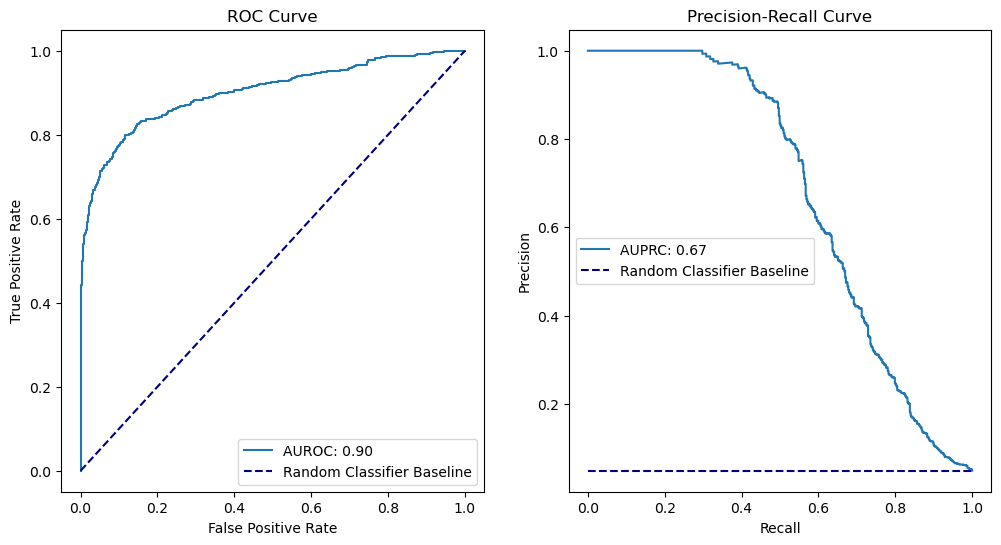

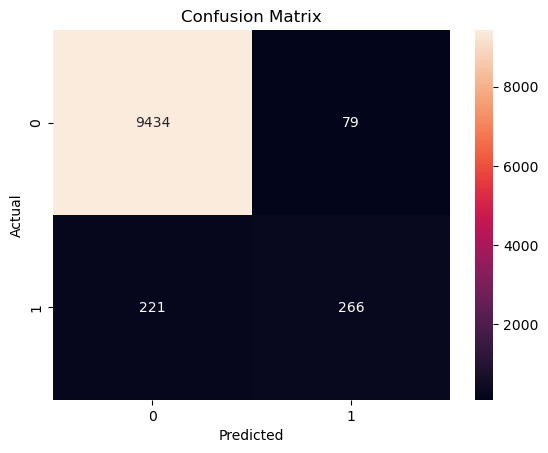

Results: AUROC=0.9008761597390451, AUPRC=0.6725000475920273, Max F1=0.6410564225690276, Best Threshold=0.03199140873560253, Precision: 0.7716763005780347, Recall: 0.5482546201232033


In [7]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
def build_models(tf, tg):
    all_models = []
    # Looping through each TG to create a model
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100, random_state=6517)
        forest.fit(tf, tg[:, i])
        all_models.append(forest)
    return all_models

# Let's calculate the scores for the gene regulatory network
def calculate_grn(models):
    importance_scores = []
    for m in models:
        # Taking feature importances as scores
        importance_scores.append(m.feature_importances_)
    return np.array(importance_scores).T  # Making sure the shape matches so that TF is rows and TG are columns *LOOK INTO DIFFERENT WAY*

# evaulate
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models = build_models(tf, tg)
grn_scores = calculate_grn(trained_models)
auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, grn_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")


## Regular Random Forest Regressor 

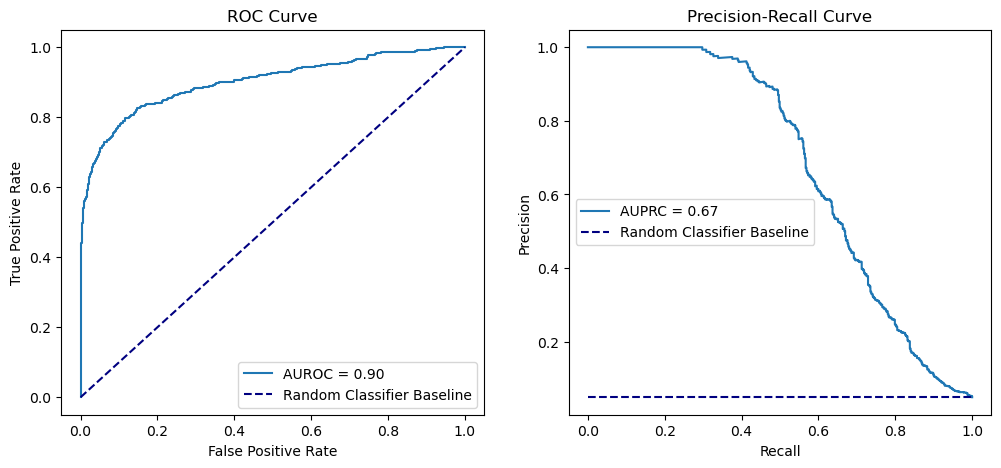

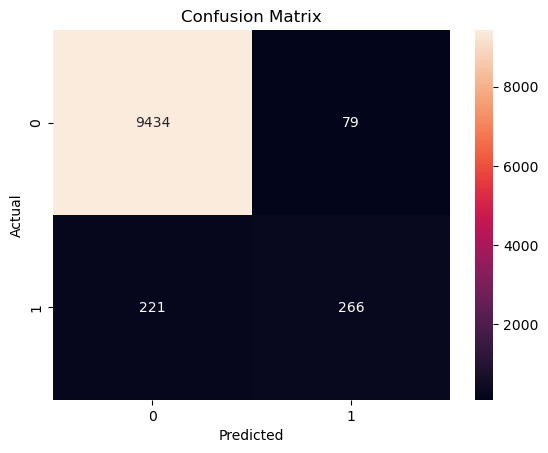

AUROC: 0.9008761597390451, AUPRC: 0.6725000475920273, Max F1 Score: 0.6410564225690276, Best Threshold: 0.03199140873560253, Precision: 0.7716763005780347, Recall: 0.5482546201232033


In [3]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  
    tg_expression = data.iloc[:, 100:].values  
    return tf_expression, tg_expression

def train_models(tf_expression, tg_expression):
    models = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])
        models.append(model)
    return models

def infer_grn_scores(models):
    scores = []
    for model in models:
        # Using feature importances as score
        scores.append(model.feature_importances_)
    return np.array(scores).T  # Transpose to align with the shape of tf_expression


def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    # Prepare ground truth labels
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1  # Adjust index for TGs

    # Flatten arrays for evaluations
    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    # Compute AUROC and AUPRC
    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    # Compute precision-recall curve and F1 score
    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]

    # Plotting ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Displaying the confusion matrix for the best F1 score
    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold, best_precision, best_recall


# Load your data and adjust file path as necessary!
tf_expression, tg_expression = load_data(expression_file)

# Train a model for each target gene
models = train_models(tf_expression, tg_expression)

# Get scores from the GRN models
scores = infer_grn_scores(models)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold, precision, recall = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}, Precision: {precision}, Recall: {recall}")


# Random Forest Regressor with Friedman and Possion Criterion

## Friedman MSE

HERE ARE TP,FP,FN
267 82 220
Precision: 0.7650429799426934, Recall: 0.5482546201232033


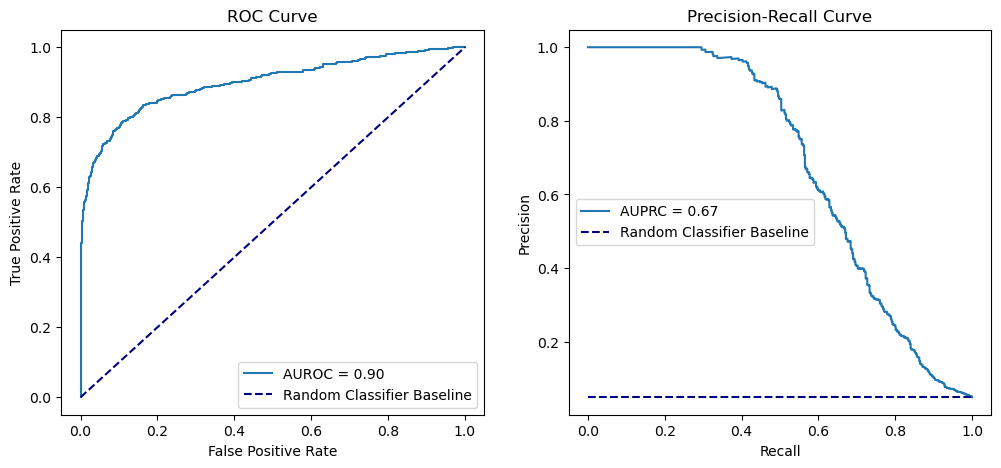

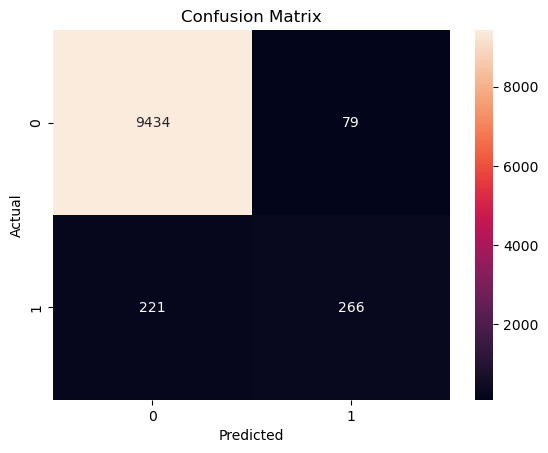

AUROC: 0.8982438599638104, AUPRC: 0.6716959776539535, Max F1 Score: 0.6410564225690276, Best Threshold: 0.032501428609646534, Precision: 0.7716763005780347, Recall: 0.5482546201232033


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
def build_models(tf, tg):
    all_models = []
    # Looping through each TG to create a model
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100, random_state=6517,criterion = "friedman_mse")
        forest.fit(tf, tg[:, i])
        all_models.append(forest)
    return all_models

# Let's calculate the scores for the gene regulatory network
def calculate_grn(models):
    importance_scores = []
    for m in models:
        # Taking feature importances as scores
        importance_scores.append(m.feature_importances_)
    return np.array(importance_scores).T  # Making sure the shape matches so that TF is rows and TG are columns *LOOK INTO DIFFERENT WAY*

# evaluation
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    #Plot auroc and auprc
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models = build_models(tf, tg)
grn_scores = calculate_grn(trained_models)
auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, grn_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")


## Poisson 

HERE ARE TP,FP,FN
269 91 218
Precision: 0.7472222222222222, Recall: 0.5523613963039015


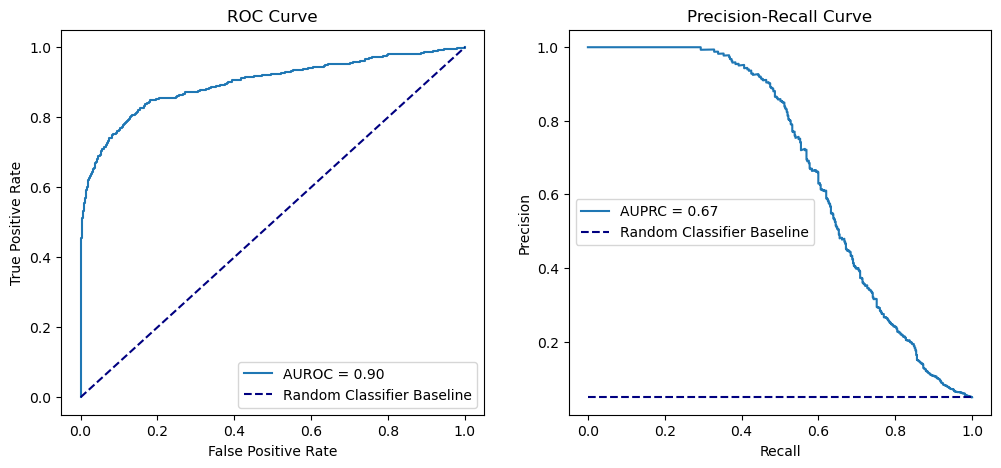

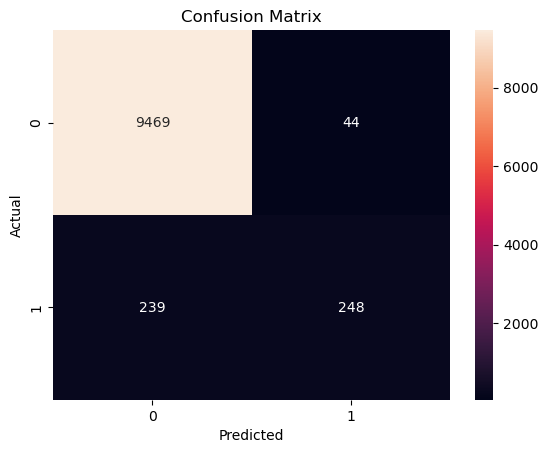

AUROC: 0.8972224542617678, AUPRC: 0.6707516874209642, Max F1 Score: 0.6384615384615384, Best Threshold: 0.03942789720125976, Precision: 0.8498293515358362, Recall: 0.5112936344969199


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
def build_models(tf, tg):
    all_models = []
    # Looping through each TG to create a model
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100, random_state=6517,criterion = "poisson")
        forest.fit(tf, tg[:, i])
        all_models.append(forest)
    return all_models

# Let's calculate the scores for the gene regulatory network
def calculate_grn(models):
    importance_scores = []
    for m in models:
        # Taking feature importances as scores
        importance_scores.append(m.feature_importances_)
    return np.array(importance_scores).T  # Making sure the shape matches so that TF is rows and TG are columns *LOOK INTO DIFFERENT WAY*

# evaluations
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
 # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models = build_models(tf, tg)
grn_scores = calculate_grn(trained_models)
auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, grn_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")



# SHAP ANALYSIS

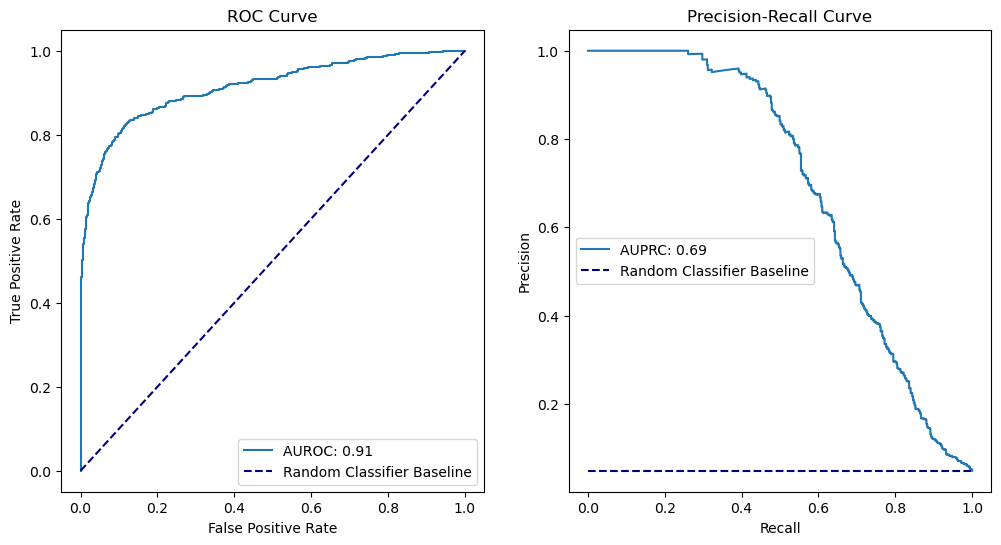

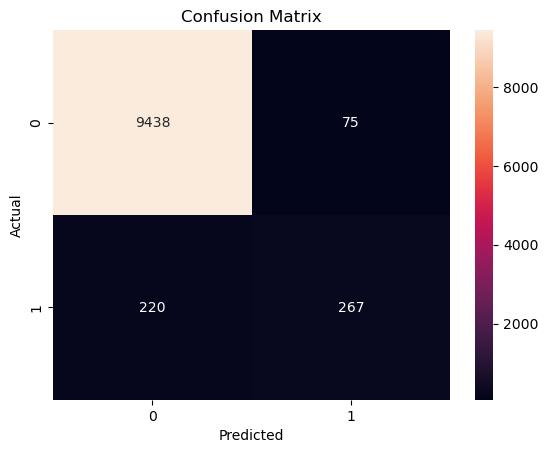

Results: AUROC=0.9137883510104297, AUPRC=0.6860468362839973, Max F1=0.6457831325301204, Best Threshold=0.09025218217368343, Precision: 0.7813411078717201, Recall: 0.5503080082135524


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
#def build_models(tf, tg):
    #all_models = []
    # Looping through each TG to create a model
    #for i in range(tg.shape[1]):
       # forest = RandomForestRegressor(n_estimators=100, random_state=6517)
       # forest.fit(tf, tg[:, i])
       # all_models.append(forest)
 #   return all_models

# Function to train models and calculate SHAP values
def build_model_shap(tf, tg):
    all_models = []
    shaplists = []
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        forest.fit(tf, tg[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(forest)
        shap_scores = explainer.shap_values(tf)
        shaplists.append(shap_scores)

        all_models.append(forest)
    return all_models, shaplists

# GRN edges using the shap scores from previous function
def grn_with_shap_scores(all_models, shap_values_list):
    scores = np.zeros((100, 100))  #100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)

        scores[:, i] = importance
    return scores

# I need to figure out how good these models are
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models,shaplists = build_model_shap(tf, tg)
shapscores = grn_with_shap_scores(trained_models, shaplists)
auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, shapscores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")


# Shap with correlation pruning!


In [107]:
def correlation_pruning_with_shap(shap_scores, expression_data, threshold):
    pruned_scores = np.zeros_like(shap_scores)
    for tf in range(shap_scores.shape[0]):  # Iterate over all TFs
        for tg in range(shap_scores.shape[1]):  # Iterate over all TGs
            correlation, _ = pearsonr(expression_data[:, tf], expression_data[:, tg + 100])  # Adjust index for TGs
            if abs(correlation) > threshold:
                pruned_scores[tf, tg] = shap_scores[tf, tg]
    return pruned_scores


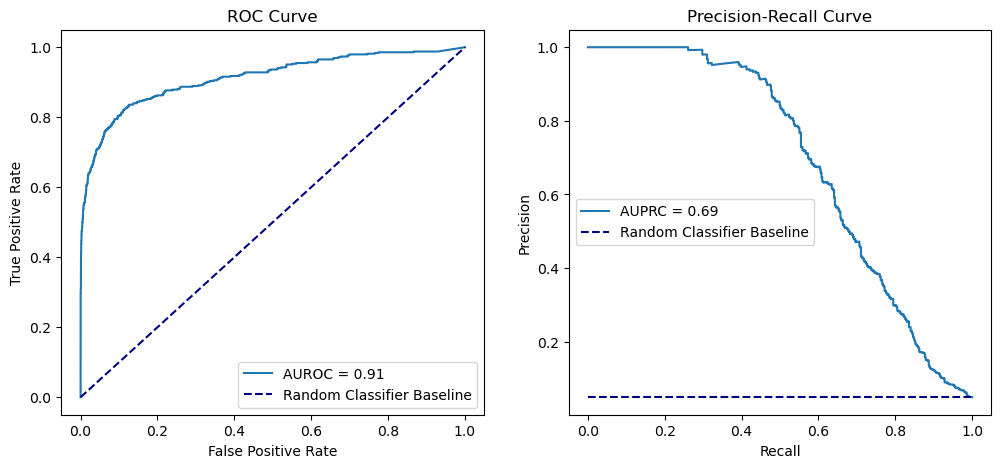

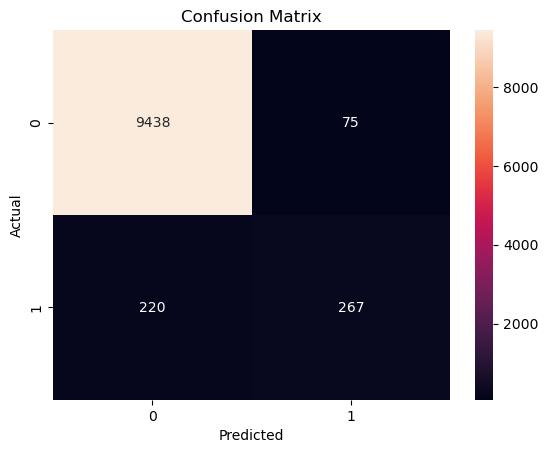

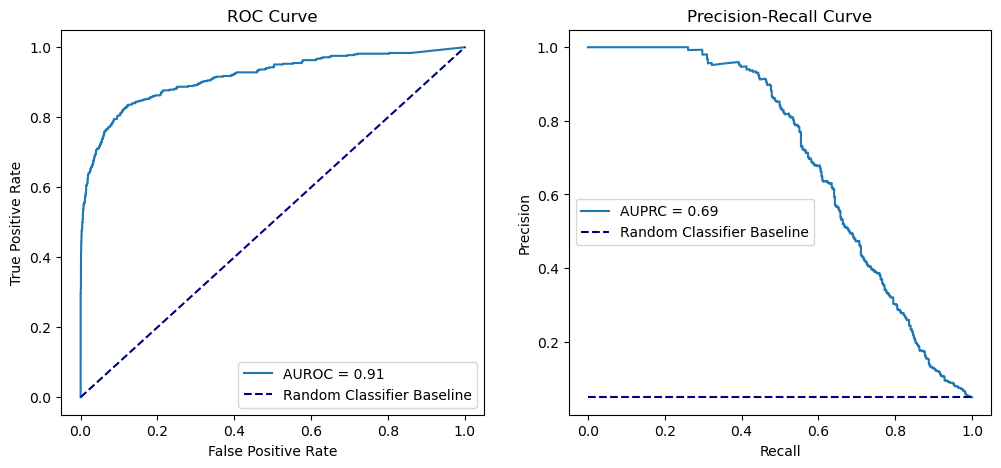

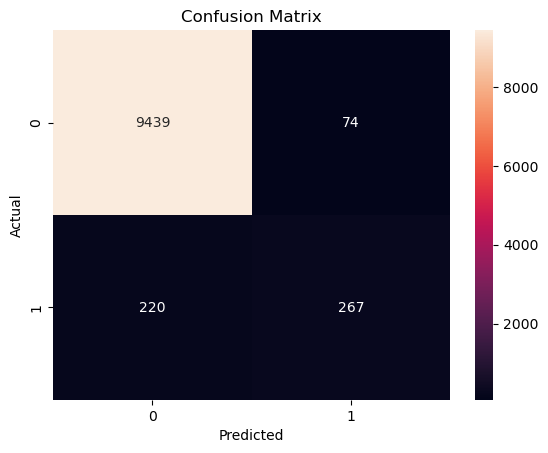

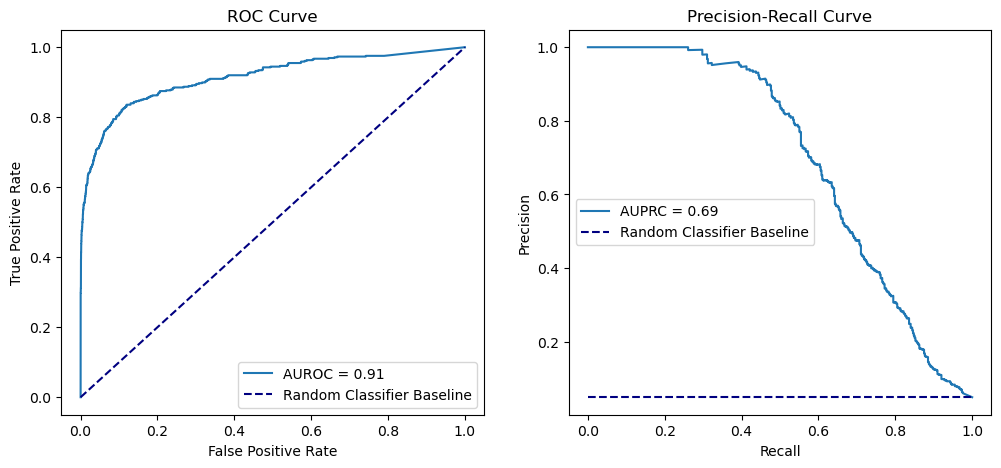

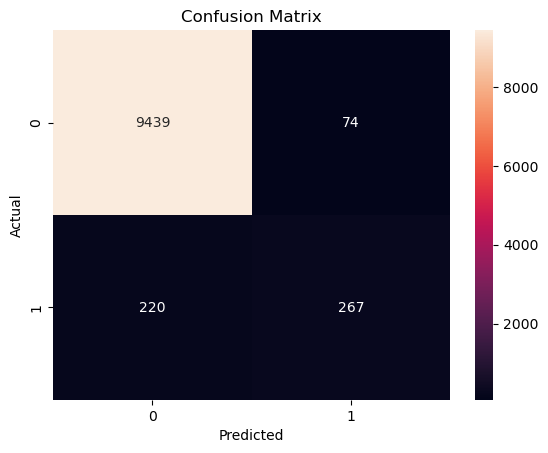

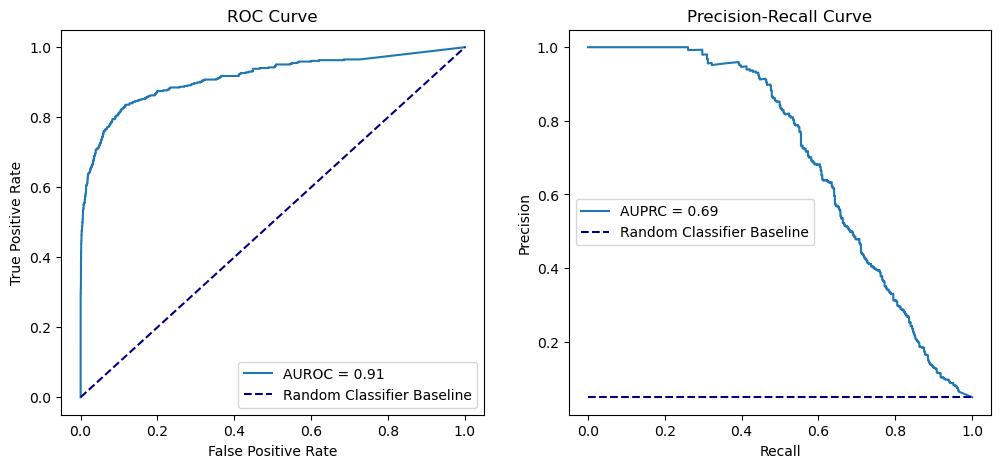

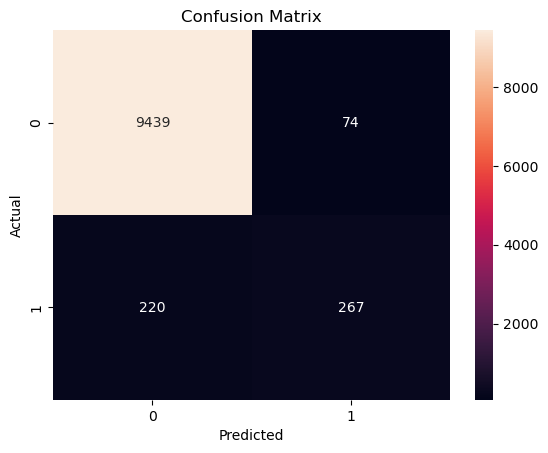

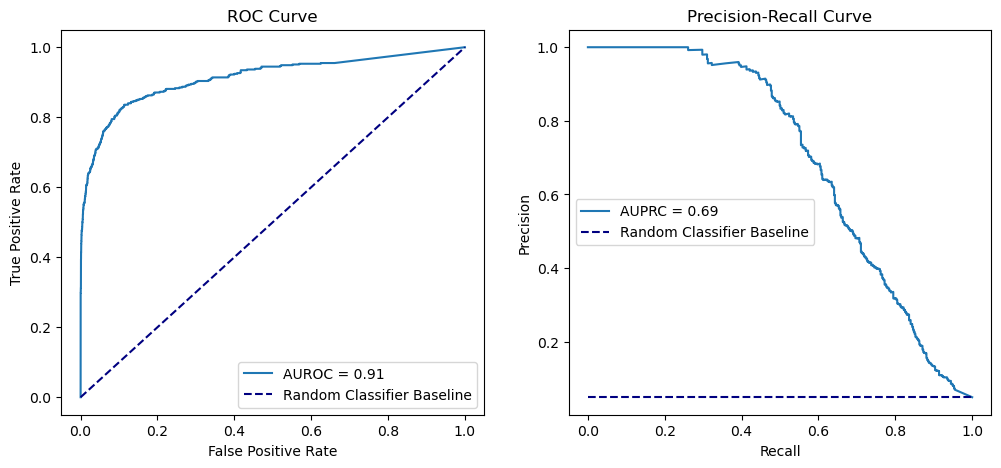

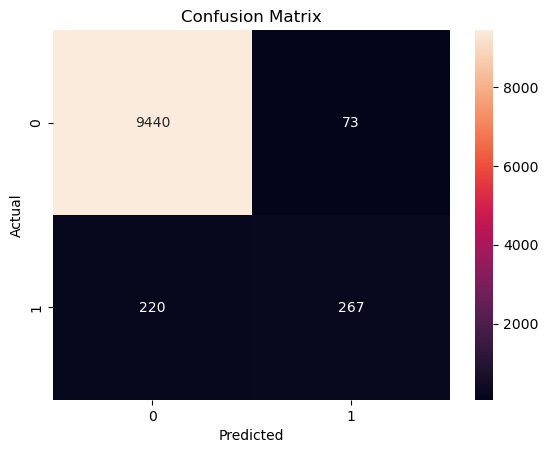

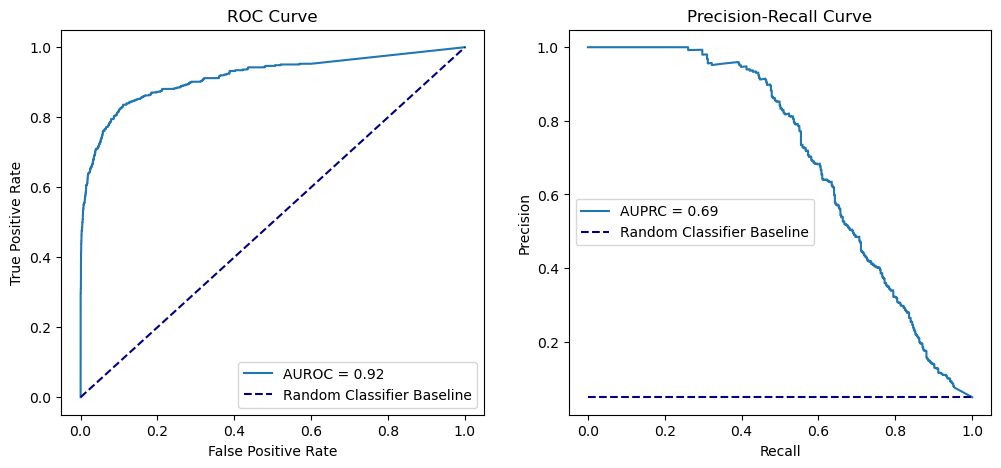

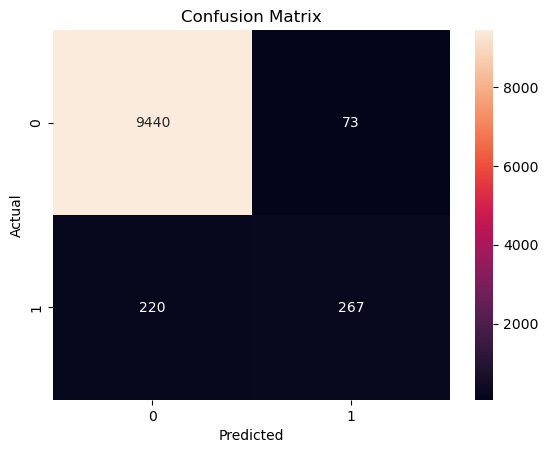

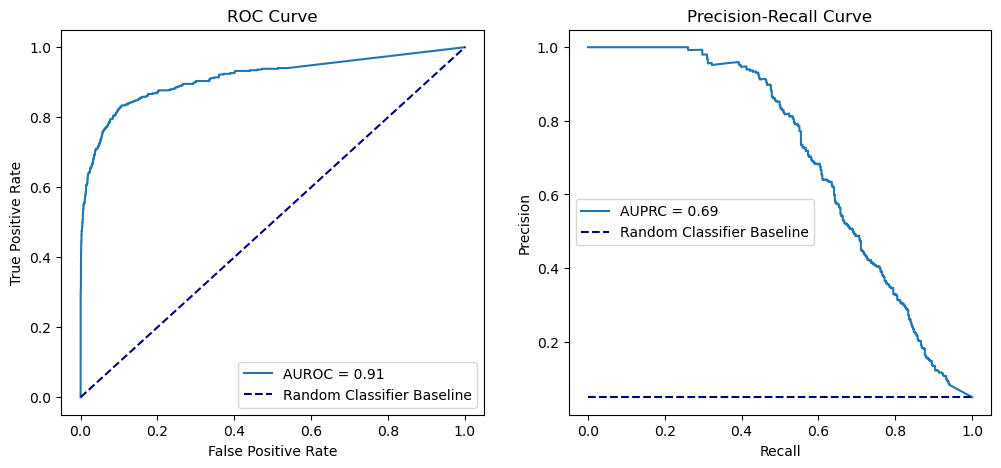

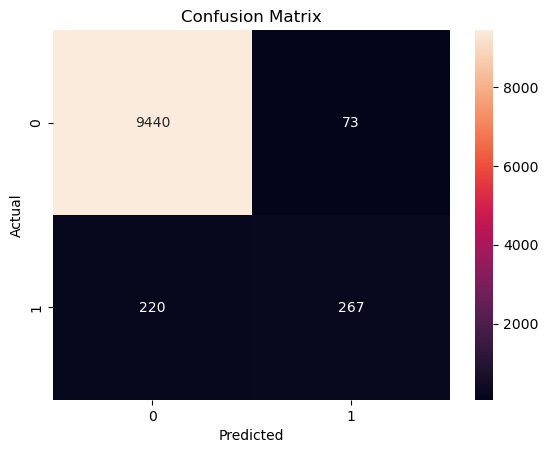

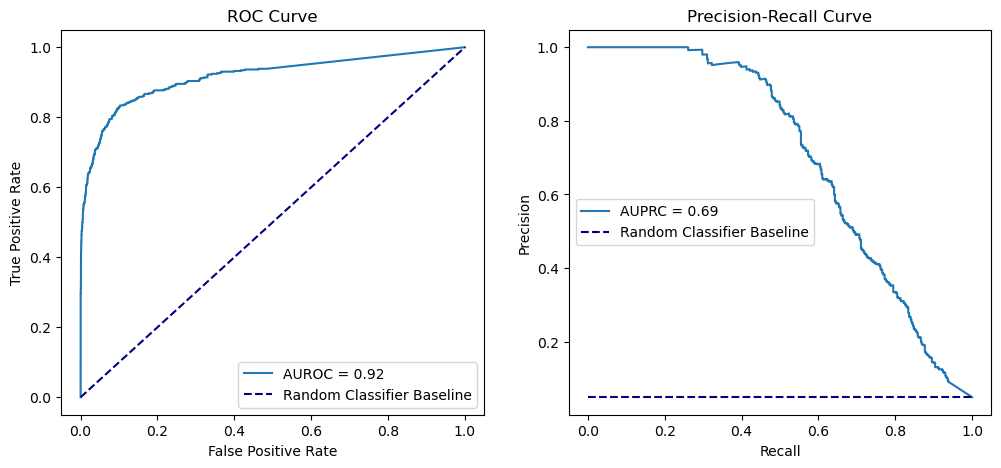

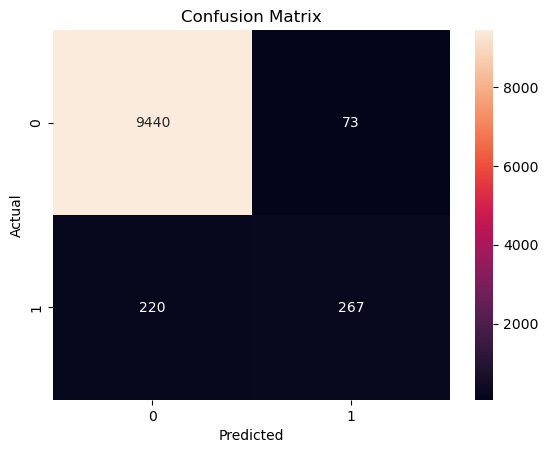

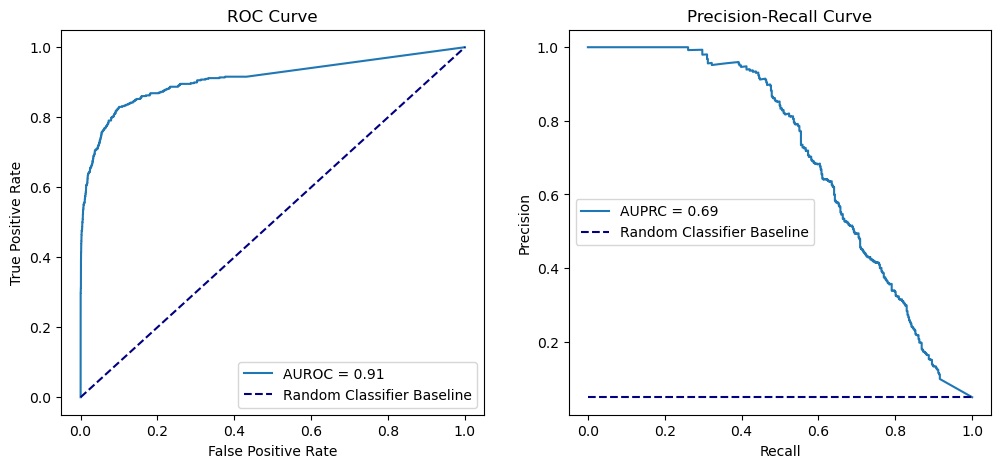

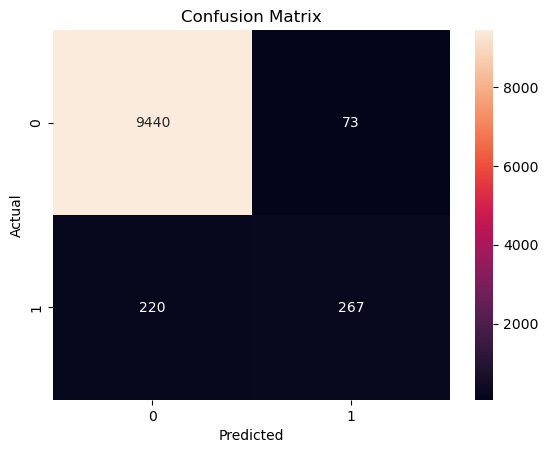

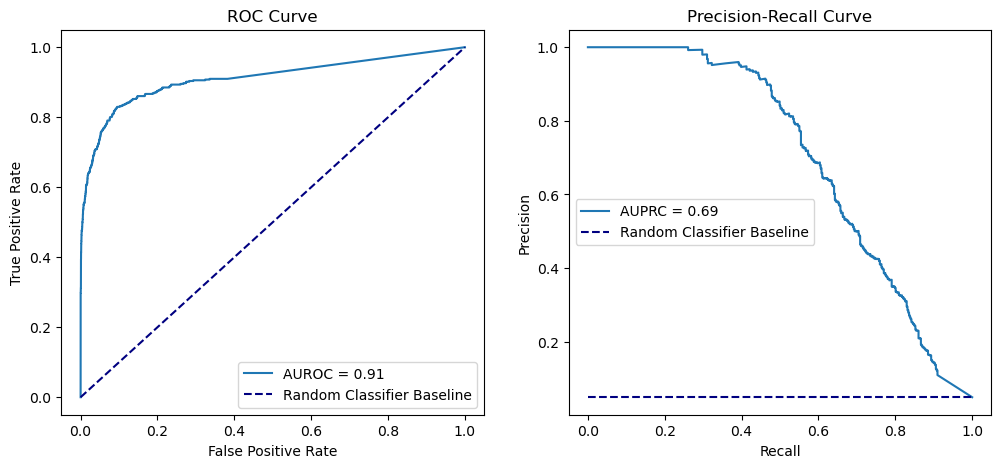

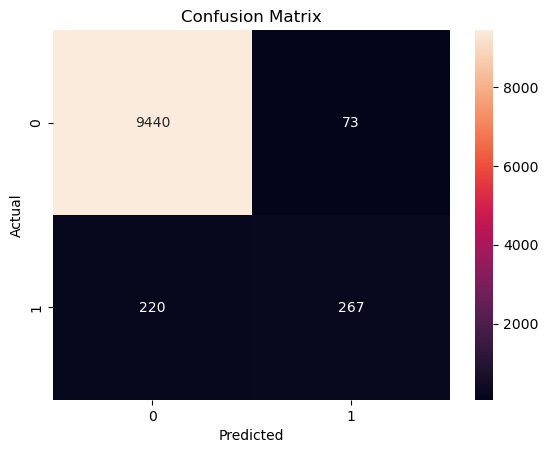

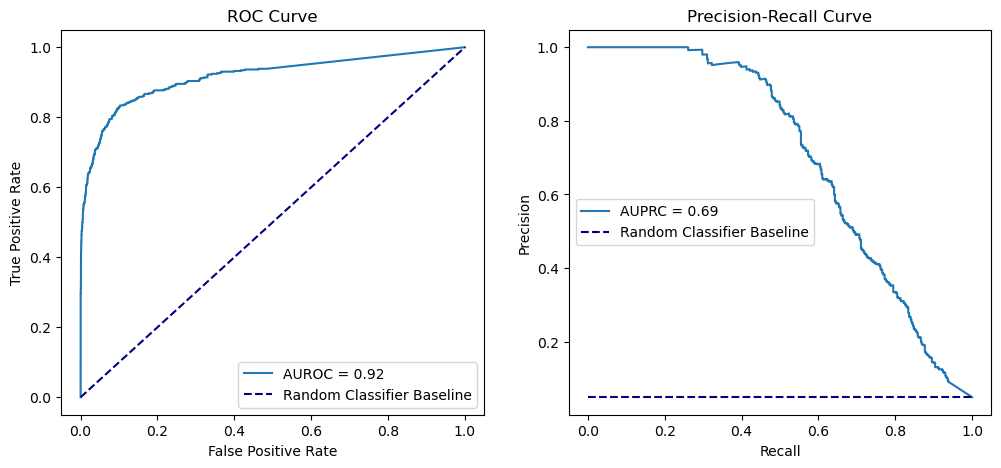

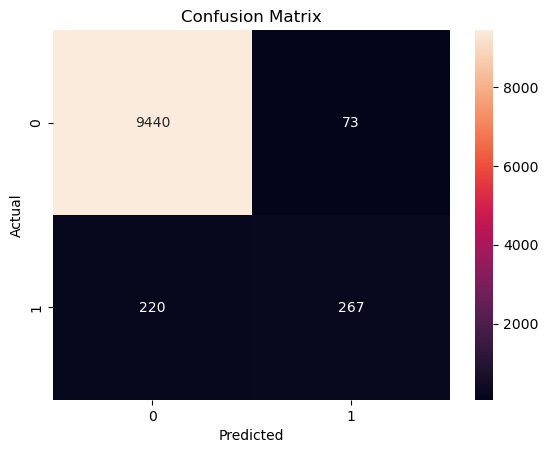

Best Threshold: 0.08, Best AUROC: 0.9162216364033137
AUROC: 0.9162216364033137, AUPRC: 0.6931180260185789, Max F1 Score: 0.6473429951690821


In [110]:
def find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds):
    best_auc = 0
    best_threshold = 0
    best_pruned_scores = None

    for threshold in correlation_thresholds:
        pruned_scores = correlation_pruning_with_shap(shap_scores, expression_data, threshold)
        auroc, auprc, max_f1, best_threshold, precision, recall = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
        
        if auroc > best_auc:  # Update the best threshold based on AUROC or other criteria
            best_auc = auroc
            best_threshold = threshold
            best_pruned_scores = pruned_scores

    return best_threshold, best_pruned_scores, best_auc

# Get SHAP scores from the GRN models
trained_models,shap_scores = build_model_shap(models, shap_values_list)

# Find the best threshold with pruning
correlation_thresholds = np.linspace(0.01, 0.1, 10) # range of thresholds
best_threshold, best_pruned_scores, best_auc = find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds)

# Evaluate and display metrics for the best threshold
auroc, auprc, max_f1, _ ,_,_= evaluate(tf_expression, tg_expression, best_pruned_scores, ground_truth_file)
print(f"Best Threshold: {best_threshold}, Best AUROC: {best_auc}")
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")


## SHAP with weighted correlation

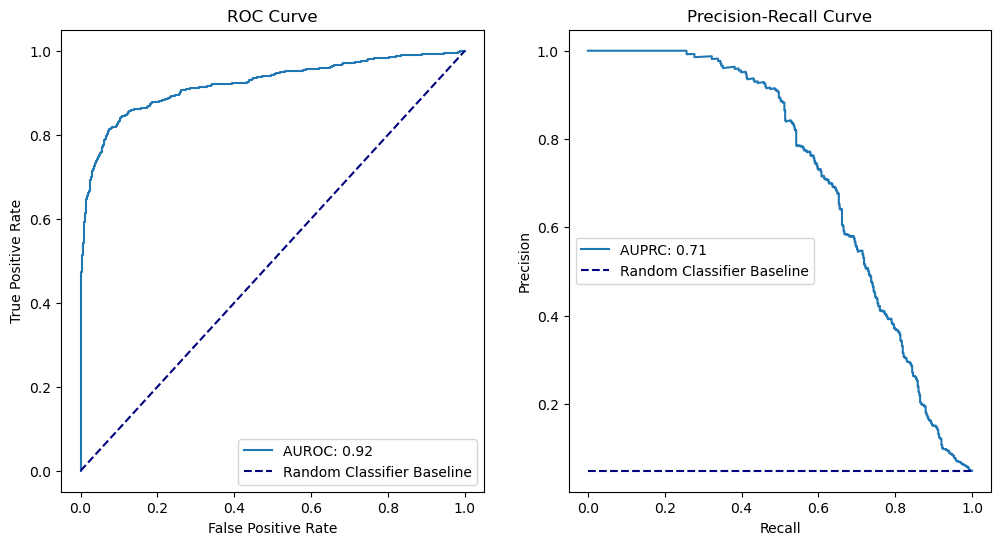

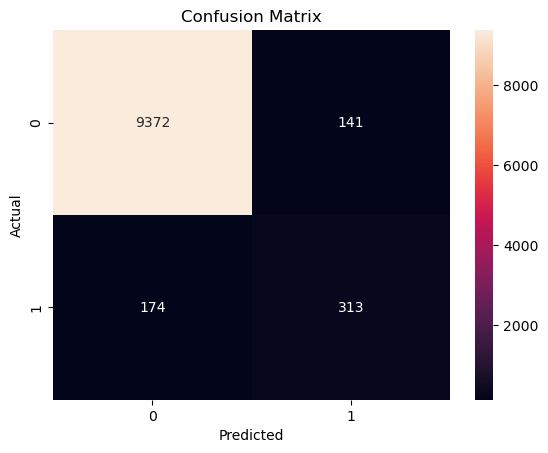

Results: AUROC=0.9210463321455067, AUPRC=0.714935583562774, Max F1=0.6666666666666667, Best Threshold=1.6465427591822448, Precision: 0.6901098901098901, Recall: 0.6447638603696099


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix
from scipy.stats import pearsonr,spearmanr

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
#def build_models(tf, tg):
    #all_models = []
    # Looping through each TG to create a model
    #for i in range(tg.shape[1]):
       # forest = RandomForestRegressor(n_estimators=100, random_state=6517)
       # forest.fit(tf, tg[:, i])
       # all_models.append(forest)
 #   return all_models

# Function to train models and calculate SHAP values
def build_model_shap(tf, tg):
    all_models = []
    shaplists = []
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        forest.fit(tf, tg[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(forest)
        shap_scores = explainer.shap_values(tf)
        shaplists.append(shap_scores)

        all_models.append(forest)
    return all_models, shaplists

# GRN edges using the shap scores from previous function
def grn_with_shap_scores(all_models, shap_values_list):
    scores = np.zeros((100, 100))  #100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)

        scores[:, i] = importance
    return scores

# I need to figure out how good these models are
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Weighted Correlation Pruning Function
def weighted_correlation_pruning(shap_scores, tfdata,tgdata, weight_factor):
    weighted_scores = np.zeros_like(shap_scores)
    num_tfs = shap_scores.shape[0]  # Assuming the number of TFs
    num_tgs = shap_scores.shape[1]  # Assuming the number of TGs

    for tf in range(num_tfs):
        for tg in range(num_tgs):
            correlation, _ = pearsonr(tfdata[:, tf], tgdata[:, tg])
            weighted_scores[tf, tg] = shap_scores[tf, tg] * (1 + abs(correlation) * weight_factor)

    return weighted_scores

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models,shaplists = build_model_shap(tf, tg)
shap_scores = grn_with_shap_scores(trained_models, shaplists)
weighted_scores = weighted_correlation_pruning(shap_scores, tf,tg , weight_factor=100)
auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, weighted_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")



## Spearman's Rank Correlation for Weighted Pruning

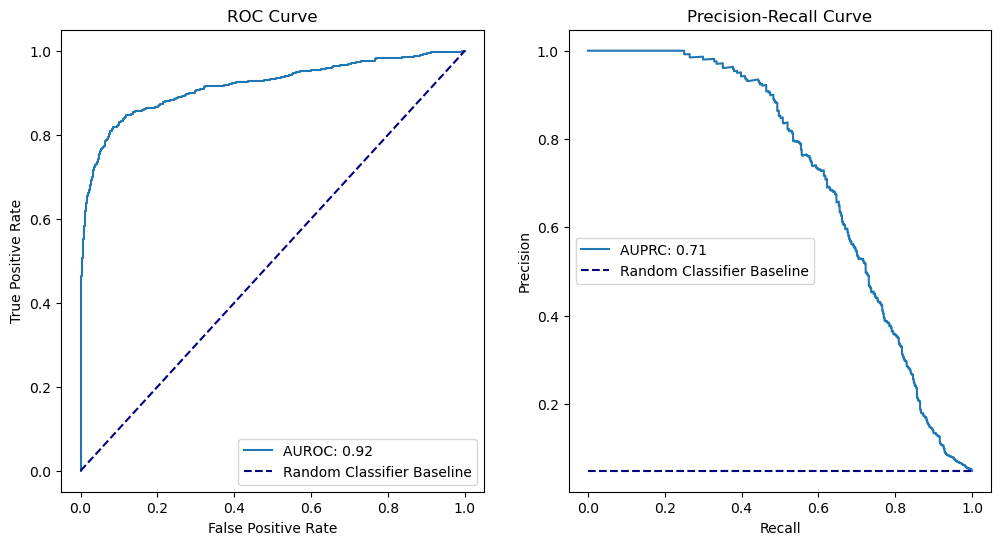

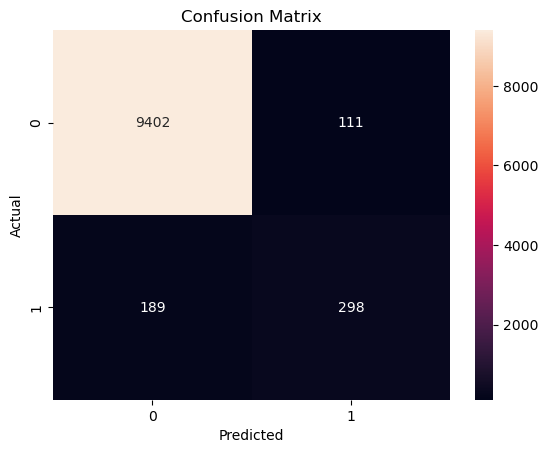

Results: AUROC=0.9171933964351386, AUPRC=0.7083708495046159, Max F1=0.6666666666666666, Best Threshold=1.9136388779891491, Precision: 0.7292682926829268, Recall: 0.6139630390143738


In [17]:

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
#def build_models(tf, tg):
    #all_models = []
    # Looping through each TG to create a model
    #for i in range(tg.shape[1]):
       # forest = RandomForestRegressor(n_estimators=100, random_state=6517)
       # forest.fit(tf, tg[:, i])
       # all_models.append(forest)
 #   return all_models

# Function to train models and calculate SHAP values
def build_model_shap(tf, tg):
    all_models = []
    shaplists = []
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        forest.fit(tf, tg[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(forest)
        shap_scores = explainer.shap_values(tf)
        shaplists.append(shap_scores)

        all_models.append(forest)
    return all_models, shaplists

# GRN edges using the shap scores from previous function
def grn_with_shap_scores(all_models, shap_values_list):
    scores = np.zeros((100, 100))  #100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)

        scores[:, i] = importance
    return scores

# I need to figure out how good these models are
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Weighted Correlation Pruning Function
def weighted_correlation_pruning_spearman(shap_scores, tfdata,tgdata, weight_factor):
    weighted_scores = np.zeros_like(shap_scores)
    num_tfs = shap_scores.shape[0]  # Assuming the number of TFs
    num_tgs = shap_scores.shape[1]  # Assuming the number of TGs

    for tf in range(num_tfs):
        for tg in range(num_tgs):
            correlation, _ = spearmanr(tfdata[:, tf], tgdata[:, tg])
            weighted_scores[tf, tg] = shap_scores[tf, tg] * (1 + abs(correlation) * weight_factor)

    return weighted_scores

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models,shaplists = build_model_shap(tf, tg)
shap_scores = grn_with_shap_scores(trained_models, shaplists)
weighted_scores = weighted_correlation_pruning_spearman(shap_scores, tf,tg , weight_factor=100)
auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, weighted_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")



## Mutual information and SHAP scores combined by arthimetic average


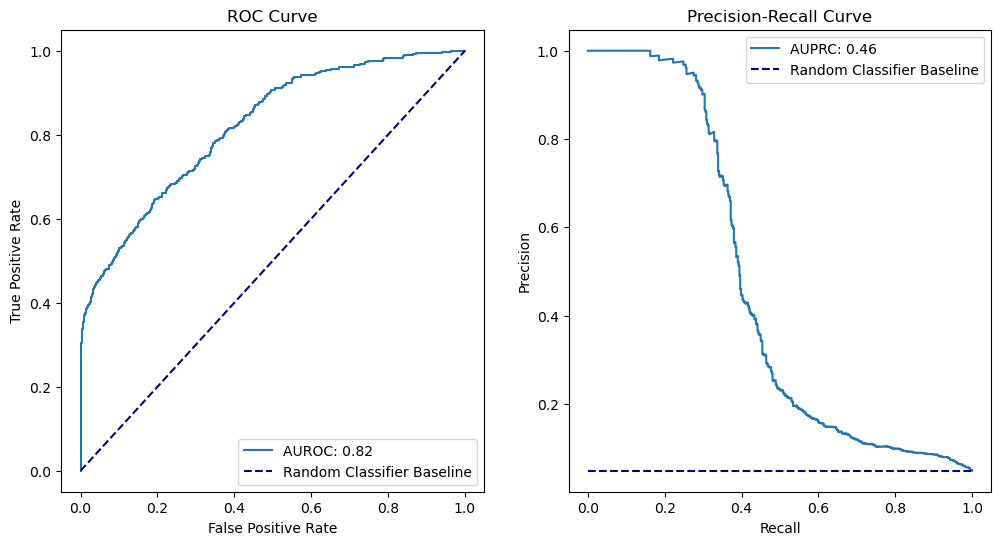

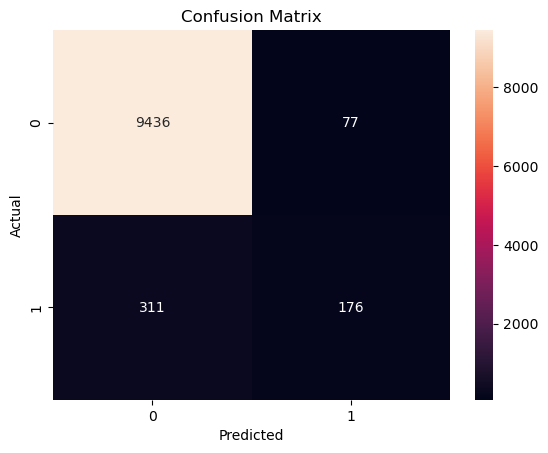

Results: AUROC=0.8194563971791762, AUPRC=0.46004902285612026, Max F1=0.4777327935222672, Best Threshold=0.18650987523018203, Precision: 0.6968503937007874, Recall: 0.36344969199178645


In [19]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
#def build_models(tf, tg):
    #all_models = []
    # Looping through each TG to create a model
    #for i in range(tg.shape[1]):
       # forest = RandomForestRegressor(n_estimators=100, random_state=6517)
       # forest.fit(tf, tg[:, i])
       # all_models.append(forest)
 #   return all_models

# Function to train models and calculate SHAP values
def build_model_shap(tf, tg):
    all_models = []
    shaplists = []
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        forest.fit(tf, tg[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(forest)
        shap_scores = explainer.shap_values(tf)
        shaplists.append(shap_scores)

        all_models.append(forest)
    return all_models, shaplists

# GRN edges using the shap scores from previous function
def grn_with_shap_scores(all_models, shap_values_list):
    scores = np.zeros((100, 100))  #100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)

        scores[:, i] = importance
    return scores

# I need to figure out how good these models are
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Function to calculate mutual information
def mutual_information(tf_expression, tg_expression):
    mi_scores = np.zeros((tf_expression.shape[1], tg_expression.shape[1]))  # 100 TFs x 100 TGs
    for i in range(tg_expression.shape[1]):
        mi_scores[:, i] = mutual_info_regression(tf_expression, tg_expression[:, i])
    return mi_scores

# Function to integrate SHAP and MI scores
def shap_mi(shap_scores, mi_scores):
    normalized_shap = shap_scores / np.max(shap_scores)
    normalized_mi = mi_scores / np.max(mi_scores)
    combined_scores = (normalized_shap + normalized_mi) / 2
    return combined_scores

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models,shaplists = build_model_shap(tf, tg)
shap_scores = grn_with_shap_scores(trained_models, shaplists)
mi_scores = mutual_information(tf,tg)
combined_scores = shap_mi(shap_scores, mi_scores)

auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, combined_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")


## Harmonic Mean with shap and mutual information

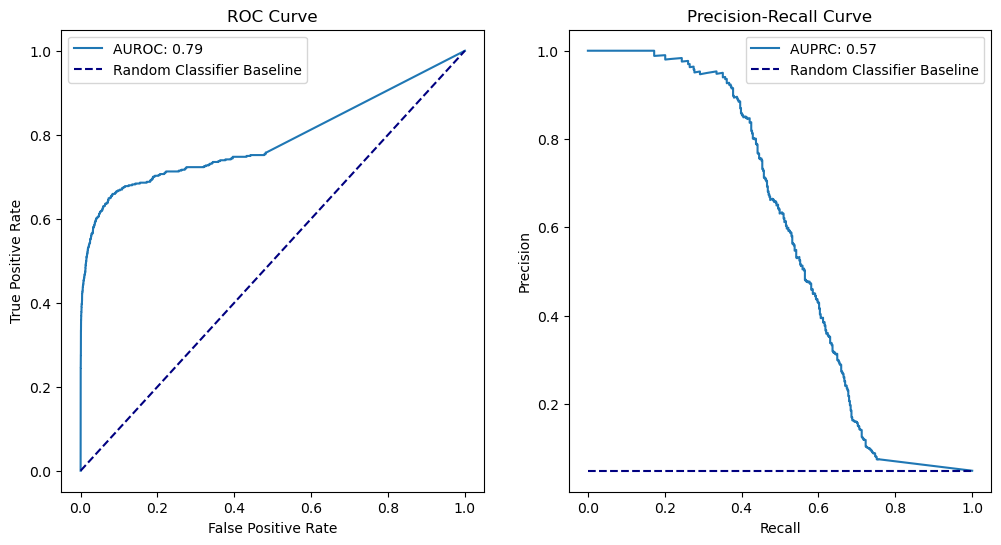

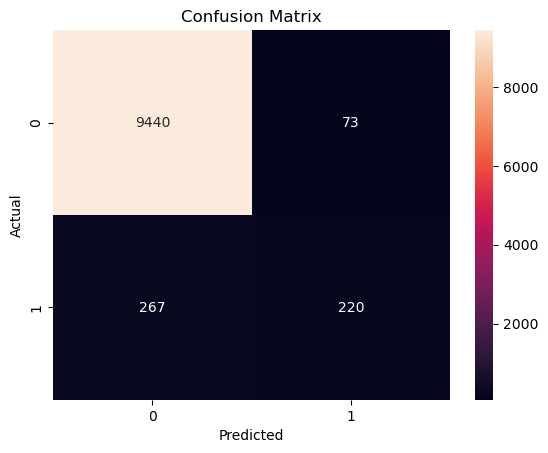

Results: AUROC=0.7884792257692973, AUPRC=0.5651967621077, Max F1=0.5659411011523686, Best Threshold=0.08693942388280258, Precision: 0.7517006802721088, Recall: 0.4537987679671458


In [20]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
#def build_models(tf, tg):
    #all_models = []
    # Looping through each TG to create a model
    #for i in range(tg.shape[1]):
       # forest = RandomForestRegressor(n_estimators=100, random_state=6517)
       # forest.fit(tf, tg[:, i])
       # all_models.append(forest)
 #   return all_models

# Function to train models and calculate SHAP values
def build_model_shap(tf, tg):
    all_models = []
    shaplists = []
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        forest.fit(tf, tg[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(forest)
        shap_scores = explainer.shap_values(tf)
        shaplists.append(shap_scores)

        all_models.append(forest)
    return all_models, shaplists

# GRN edges using the shap scores from previous function
def grn_with_shap_scores(all_models, shap_values_list):
    scores = np.zeros((100, 100))  #100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)

        scores[:, i] = importance
    return scores

# I need to figure out how good these models are
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Function to calculate mutual information
def mutual_information(tf_expression, tg_expression):
    mi_scores = np.zeros((tf_expression.shape[1], tg_expression.shape[1]))  # 100 TFs x 100 TGs
    for i in range(tg_expression.shape[1]):
        mi_scores[:, i] = mutual_info_regression(tf_expression, tg_expression[:, i])
    return mi_scores

# Function to integrate SHAP and MI scores using harmonic mean
def shap_mi_harmonic_mean(shap_scores, mi_scores):
    normalized_shap = shap_scores / np.max(shap_scores)
    normalized_mi = mi_scores / np.max(mi_scores)
    combined_scores = 2 * (normalized_shap * normalized_mi) / (normalized_shap + normalized_mi + 1e-8)  # Avoid division by zero
    return combined_scores

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models,shaplists = build_model_shap(tf, tg)
shap_scores = grn_with_shap_scores(trained_models, shaplists)
mi_scores = mutual_information(tf,tg)
combined_scores = shap_mi_harmonic_mean(shap_scores, mi_scores)

auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, combined_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")


# Mutual information byitself

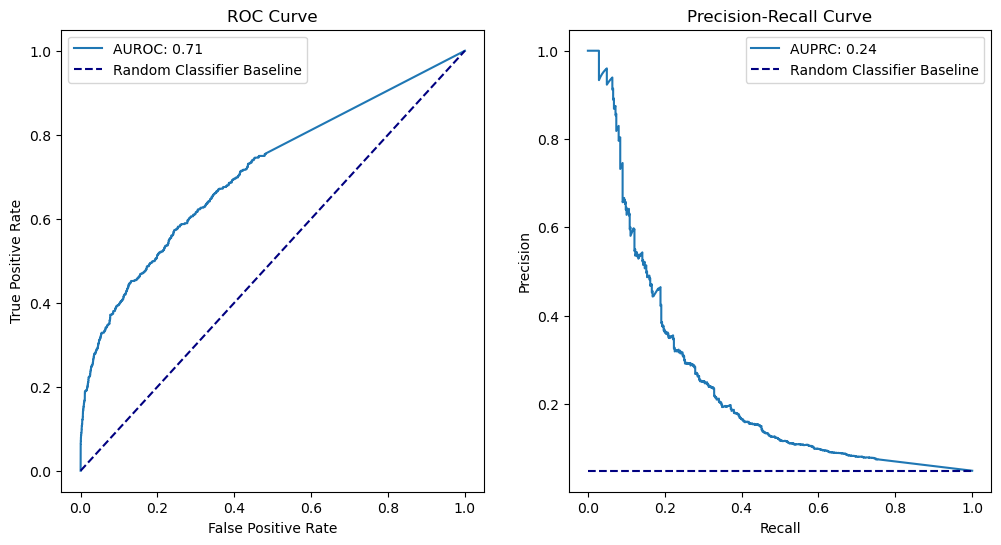

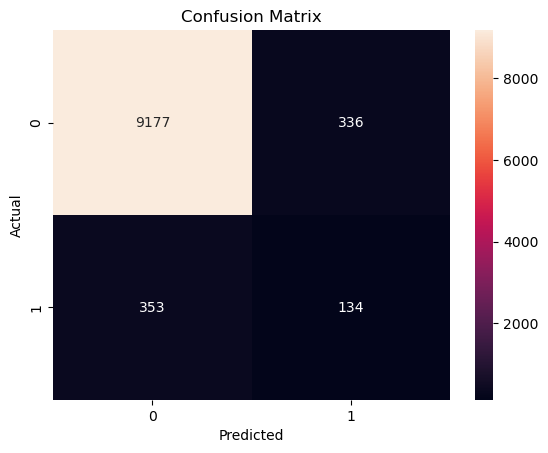

Results: AUROC=0.711803430774833, AUPRC=0.2427382759835211, Max F1=0.28183716075156573, Best Threshold=0.1252965835997264, Precision: 0.28662420382165604, Recall: 0.27720739219712526


In [21]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

# Let's start by reading the data
def read_data(file):
    # Opening the file and splitting columns for TFs and TGs
    data = pd.read_csv(file, sep="\t")
    tf = data.iloc[:, :100].values  # First 100 columns - TFs
    tg = data.iloc[:, 100:].values  # Rest - TGs
    return tf, tg

# Time to train some models
#def build_models(tf, tg):
    #all_models = []
    # Looping through each TG to create a model
    #for i in range(tg.shape[1]):
       # forest = RandomForestRegressor(n_estimators=100, random_state=6517)
       # forest.fit(tf, tg[:, i])
       # all_models.append(forest)
 #   return all_models

# Function to train models and calculate SHAP values
def build_model_shap(tf, tg):
    all_models = []
    shaplists = []
    for i in range(tg.shape[1]):
        forest = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        forest.fit(tf, tg[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(forest)
        shap_scores = explainer.shap_values(tf)
        shaplists.append(shap_scores)

        all_models.append(forest)
    return all_models, shaplists

# GRN edges using the shap scores from previous function
def grn_with_shap_scores(all_models, shap_values_list):
    scores = np.zeros((100, 100))  #100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)

        scores[:, i] = importance
    return scores

# I need to figure out how good these models are
def evaluate(tf, tg, scores, truth_path):
    truth = pd.read_csv(truth_path, header=None)
    y_truth = np.zeros_like(scores, dtype=int)
    for _, (tf_index, tg_index) in truth.iterrows():
        y_truth[tf_index, tg_index - 100] = 1  # Adjusting indexes for TGs

    scores_flat = scores.flatten()
    y_truth_flat = y_truth.flatten()

    # Calculating various metrics
    auroc = roc_auc_score(y_truth_flat, scores_flat)
    auprc = average_precision_score(y_truth_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_truth_flat, scores_flat)
    f1 = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1)
    
    # Plot the auroc and auprc curves
    plt.figure(figsize=(12, 6))
    fpr, tpr, _ = roc_curve(y_truth_flat, scores_flat)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC: {auroc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    randomclassifier_prc = sum(y_truth_flat) / len(y_truth_flat) 
    plt.plot(recall, precision, label=f'AUPRC: {auprc:.2f}')
    plt.plot([0, 1], [randomclassifier_prc, randomclassifier_prc], linestyle='--', color='navy',label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Now the confusion matrix
    best_thresh = thresholds[max_f1_index]
    best_precision = precision[max_f1_index]
    best_recall = recall[max_f1_index]
    predicted = (scores_flat > best_thresh).astype(int)
    cm = confusion_matrix(y_truth_flat, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, f1[max_f1_index], best_thresh, best_precision, best_recall

# Function to calculate mutual information
def mutual_information(tf_expression, tg_expression):
    mi_scores = np.zeros((tf_expression.shape[1], tg_expression.shape[1]))  # 100 TFs x 100 TGs
    for i in range(tg_expression.shape[1]):
        mi_scores[:, i] = mutual_info_regression(tf_expression, tg_expression[:, i])
    return mi_scores

# Load data from Project 1 folder
expression_data = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\100_mr_50_cond\bipartite_GRN.csv'

tf, tg = read_data(expression_data)
trained_models,shaplists = build_model_shap(tf, tg)
shap_scores = grn_with_shap_scores(trained_models, shaplists)
mi_scores = mutual_information(tf,tg)

auroc, auprc, max_f1, best_thresh, precision, recall = evaluate(tf, tg, mi_scores, ground_truth_file)
print(f"Results: AUROC={auroc}, AUPRC={auprc}, Max F1={max_f1}, Best Threshold={best_thresh}, Precision: {precision}, Recall: {recall}")
